# k-means

Zaimplementować swoją klasteryzację k-means i porównać ją z metodami wbudowanymi.
https://stanford.edu/~cpiech/cs221/handouts/kmeans.html

(200, 2)
[[ 9.65159833  3.90814641]
 [        nan         nan]
 [ 9.75052998  2.39986496]
 [ 6.59008149 -0.84957387]
 [-0.19553503 -0.55925765]]


c:\dev\machine_learning_1\.venv\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


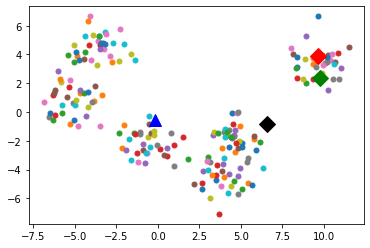

In [8]:
import numpy as np
import matplotlib.pyplot as plt

MAX_ITERATIONS = 10000

def kmeans(dataSet, k):
    numFeatures = dataSet.shape[1]
    centroids = getRandomCentroids(numFeatures, k)
    iterations = 0
    oldCentroids = None
    
    while not shouldStop(oldCentroids, centroids, iterations):
        oldCentroids = centroids
        iterations += 1

        labels = getLabels(dataSet, centroids)

        centroids = getCentroids(dataSet, labels, k)

    return centroids

def shouldStop(oldCentroids, centroids, iterations):
    if iterations > MAX_ITERATIONS: return True
    return (oldCentroids == centroids).any()

def getLabels(dataSet, centroids):
    label_list = np.zeros(len(dataSet))
    for i in range(len(dataSet)):
        old_distance = getDistance(dataSet[i], centroids[0])
        label = 0
        for j in range(len(centroids)):
            distance = getDistance(dataSet[i], centroids[j])
            if old_distance > distance:
                label = j
        label_list[i] = label
    return label_list
    
def getCentroids(dataSet, labels, k):
    col_num = dataSet.shape[1]
    sum_ = np.zeros([k, col_num])
    for i in range(k):
        index_k = np.where(labels == i)[0]
        sum_[i] = np.sum(dataSet[index_k], axis = 0) /(len(index_k))
    return sum_

def getRandomCentroids(numFeatures, k):
    centroids = np.random.normal(0,1,(k,numFeatures))
    return centroids

def getDistance(d1, d2):
    vec1 = np.array(d1)
    vec2 = np.array(d2)
    return np.sqrt(np.sum(np.square(vec1-vec2)))

from sklearn.datasets import make_blobs
if __name__ == '__main__' :
    X_varied, y = make_blobs(n_samples=200,
                                centers=6,
                                n_features=2,
                                # cluster_std=[1.0, 2.5, 0.5],
                                random_state=123)
    print(X_varied.shape)
    k = 5
    c = kmeans(X_varied, k)
    print(c)
    for i in range(len(X_varied)):
        plt.plot(X_varied[i, 0], X_varied[i, 1], marker='o', markersize = 5)
    mark = ['Dr', 'Db', 'Dg', 'Dk', '^b', '+b', 'sb', 'db', '<b', 'pb']
    for i in range(k):
        plt.plot(c[i, 0], c[i, 1], mark[i], markersize = 12)
    plt.show()